# 赛题介绍

- 赛题名称：Detect AI Generated Text
- 赛题类型：文本分类、自然语言处理
- 赛题任务：识别哪篇文章是由大型语言模型撰写的
- 赛题链接：https://www.kaggle.com/competitions/llm-detect-ai-generated-text/


赛题涉及建立一个模型来区分中学和高中学生所写的文章与由大型语言模型（LLM）所写的文章。由于LLMs的广泛使用，很多人担心它们将取代或改变通常由人类完成的工作。教育工作者特别担心它们对学生技能发展的影响，尽管很多人对LLMs最终成为帮助学生提高写作技能的有用工具持乐观态度。

在学术界对LLMs的主要担忧之一是它们可能助长抄袭行为。LLMs是在大规模文本和代码数据集上训练的，这意味着它们能够生成与人类写作非常相似的文本。

# 赛题任务

参赛选手在这个竞赛中的工作可以帮助识别LLM的痕迹，并推动LLM文本检测的技术。

# 赛题数据

竞赛数据集包含大约10,000篇文章，其中一部分由学生撰写，一部分由各种大型语言模型（LLMs）生成。竞赛的目标是确定一篇文章是否由LLM生成。

所有的文章都是作为对七个不同的作文题目之一的回应而写的。在每个题目中，学生被要求阅读一个或多个源文本，然后写出回应。这些信息可能会或者不会作为LLM生成文章的输入。

两个题目的作文构成了训练集，其余的作文构成了隐藏的测试集。几乎所有的训练集作文都是由学生写的，只有少数生成的作文作为示例。您可以考虑生成更多的作文来用作训练数据。

**文件和字段信息**：

-   {test/train}_essays.csv
    -   `id` - 每篇文章的唯一标识符。
    -   `prompt_id` - 识别文章是回应哪个作文题目写的。
    -   `text` - 文章正文。
    -   `generated` - 文章是由学生写的 (`0`) 还是由LLM生成的 (`1`)。这个字段是目标变量，在`test_essays.csv`中不包括。

-   train_prompts.csv
    -   `prompt_id` - 每个作文题目的唯一标识符。
    -   `prompt_name` - 作文题目的标题。
    -   `instructions` - 给学生的指示。
    -   `source_text` - 文章或文章的文本，这些文章是学生在回应中编写的，采用Markdown格式。

-   sample_submission.csv - 一个格式正确的提交文件。

# 评价指标

提交的内容根据预测概率与观察目标之间的 ROC 曲线下面积进行评估。

对于测试集中的每个 id，您必须预测生成该文章的概率。该文件应包含标头并具有以下格式：

```
id,generated
0000aaaa,0.1
1111bbbb,0.9
2222cccc,0.4
...
```

# 赛题赛程

- 2023 年 10 月 31 日 - 开始日期。
- 2024 年 1 月 15 日 - 报名截止日期。
- 2024 年 1 月 15 日 - 合并截止日期。
- 2024 年 1 月 22 日 - 提交截止日期。

# 解题思路

- 基于训练的分类器（Training-based）：通常是在已收集的二进制数据上对预训练语言模型进行微调，这些数据包括人类生成和AI生成的文本分布。
- 零-shot检测器（Zero-Shot）：利用典型LLM的内在特性，如概率曲线或表示空间，进行自我检测。
- 水印技术（Watermarking）：涉及将可识别信息隐藏在生成的文本中，以后可以用于确定文本是否来自特定的语言模型，而不仅仅是检测AI生成的文本。

# 导入环境

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from datasets import Dataset
from transformers import PreTrainedTokenizerFast



# 数据路径
# DATA_PATH = './input'
DATA_PATH = '/kaggle/input/llm-detect-ai-generated-text'

# 读取训练集文章数据
train_essays = pd.read_csv(f'{DATA_PATH}/train_essays.csv')

# 读取训练集作文题目数据
train_prompts = pd.read_csv(f'{DATA_PATH}/train_prompts.csv')

# 读取测试集文章数据
test_essays = pd.read_csv(f'{DATA_PATH}/test_essays.csv')

# 读取样本提交文件
sample_submit = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

In [2]:
# 输出训练集文章、训练集作文题目和测试集文章的形状
train_essays.shape, train_prompts.shape, test_essays.shape

((1378, 4), (2, 4), (3, 3))

# 数据分析

https://www.kaggle.com/code/pamin2222/ai-or-not-ai-delving-into-essays-with-eda

In [3]:
# 显示训练集文章的第一行数据
train_essays.head(1)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0


In [4]:
# 显示训练集作文题目的第一行数据
train_prompts.head(1)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."


In [5]:
# 显示测试集文章的第一行数据
test_essays.head(1)

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.


In [6]:
# 使用 prompt_id 列进行右连接，将训练集文章和训练集作文题目合并
train_essays = pd.merge(train_prompts, train_essays, on='prompt_id', how='right')

# 显示合并后的训练集文章的第一行数据
train_essays.head(1)

,prompt_id,prompt_name,instructions,source_text,id,text,generated
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0059830c,Cars. Cars have been around since they became ...,0


In [7]:
# 使用 prompt_id 列进行右连接，将训练集作文题目和测试集文章合并
test_essays = pd.merge(train_prompts, test_essays, on='prompt_id', how='right')

# 显示合并后的测试集文章的第一行数据
test_essays.head(1)

,prompt_id,prompt_name,instructions,source_text,id,text
0,2,NaN,NaN,NaN,0000aaaa,Aaa bbb ccc.


In [8]:
# 统计训练集文章中 'generated' 列的取值数量
train_essays['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

## Distribution of Essay Lengths

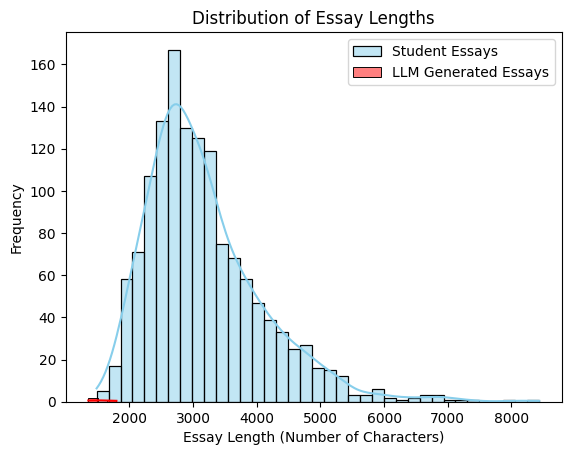

In [9]:
# 计算每篇文章的长度并创建一个新列
train_essays['essay_length'] = train_essays['text'].apply(len)

# 绘制学生写的文章长度分布
sns.histplot(train_essays[train_essays['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)
# 绘制LLM生成的文章长度分布
sns.histplot(train_essays[train_essays['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Comparison of Essay Lengths by Source

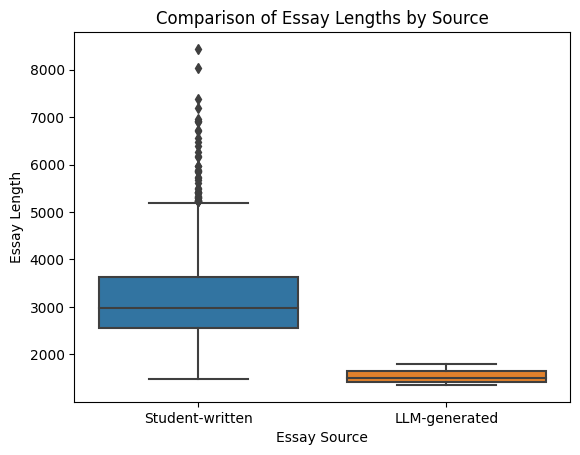

In [10]:
# 绘制箱线图比较文章长度，按来源分为学生写的和LLM生成的
sns.boxplot(x='generated', y='essay_length', data=train_essays)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

In [11]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length


# 将函数应用于 'text' 列
train_essays['metrics'] = train_essays['text'].apply(calculate_text_metrics_simple)

# 将 'metrics' 列展开为单独的列
train_essays[
    ['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']
] = pd.DataFrame(train_essays['metrics'].tolist(), index=train_essays.index)
train_essays.drop('metrics', axis=1, inplace=True)

# 按 'generated' 分组，比较学生写的和LLM生成的文章之间的这些指标
comparison_metrics = train_essays.groupby('generated')[
    ['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']
].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,556.768727,275.334545,30.063273,4.694868
1,260.666667,146.333333,13.000000,4.935610


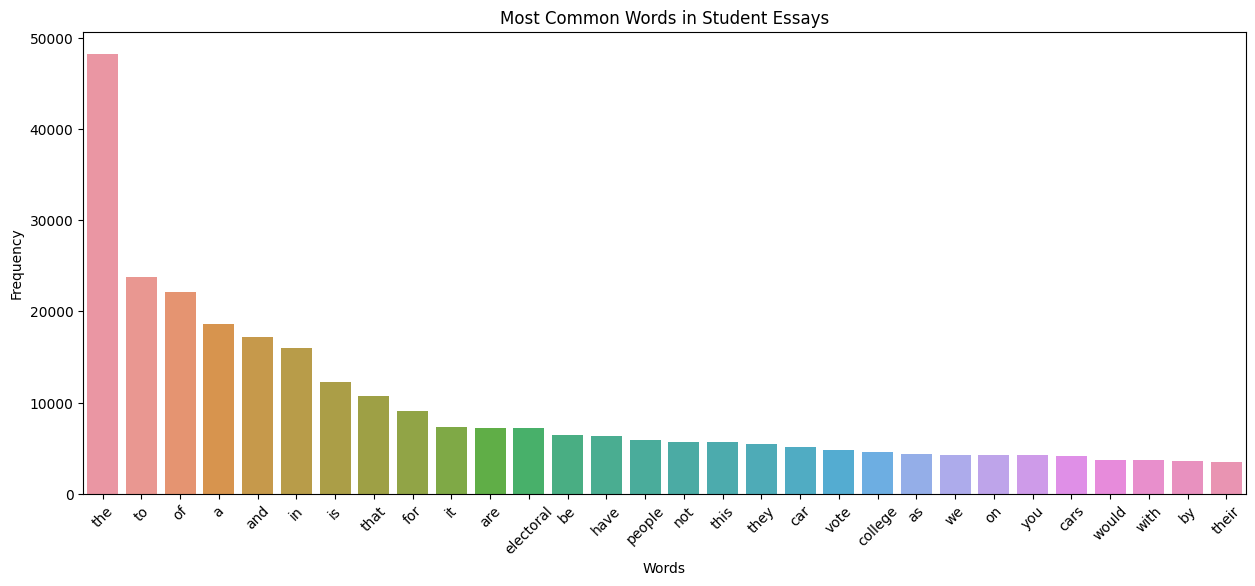

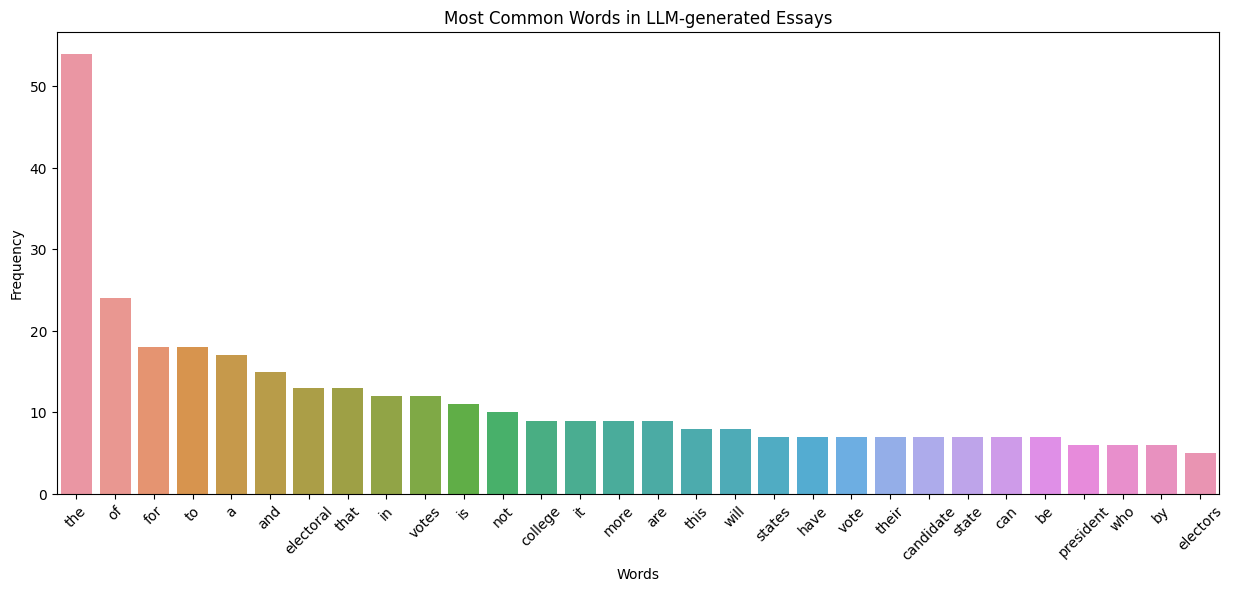

In [12]:
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)

    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# 绘制学生写的文章中最常见的单词
plot_most_common_words(train_essays[train_essays['generated'] == 0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(train_essays[train_essays['generated'] == 1]['text'], title="Most Common Words in LLM-generated Essays")

# 建模过程

## XGBoost人工特征

https://www.kaggle.com/code/tivfrvqhs5/20-feature-xgboost

```python
import re
import statistics

def mean_diff_in_sentence_length_per_paragraph(text):
    # 按双换行符拆分段落
    paragraphs = text.split('\n\n')
    
    mean_diffs = []
    
    # 遍历每个段落
    for paragraph in paragraphs:
        # 按句号、问号、感叹号拆分句子
        sentences = re.split(r'[.?!]+', paragraph)
        
        # 计算每个句子的单词数
        sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence.strip()]
        
        # 计算相邻句子长度差异
        differences = [abs(sentence_lengths[i] - sentence_lengths[i+1]) for i in range(len(sentence_lengths) - 1)]
        
        if differences:
            # 计算平均差异
            mean_diff = statistics.mean(differences)
        else:
            mean_diff = 0  # 处理没有连续句子或只有空句子的情况
        mean_diffs.append(mean_diff)
    
    return mean_diffs

def detect_word_although(text):
    # 按双换行符拆分段落
    paragraphs = text.split('\n\n')
    
    # 判断每个段落是否包含 'although'
    presence = [1 if 'although' in paragraph.lower() else 0 for paragraph in paragraphs]
    
    return presence

```

## DeBERTa文本分类

https://www.kaggle.com/code/alejopaullier/daigt-deberta-text-classification-train

https://www.kaggle.com/code/alejopaullier/daigt-deberta-text-classification-inference

```python
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.dropout = 0.2
        # Load config by inferencing it from the model name.
        if config_path is None: 
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)
        
        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()
        
        self.pool = MeanPooling()
        self.head = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(16, 1)
        )
        self._init_weights(self.head)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.head(feature)
        return output
```

## Tokenizer + TFIDF

https://www.kaggle.com/code/verracodeguacas/sentencepiece-constructions

https://www.kaggle.com/code/hubert101/0-960-phrases-are-keys/


In [13]:
# 加载外数据集
train_v2_drcat_02_path = '/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv'
# train_v2_drcat_02_path = './train_v2_drcat_02.csv'
train = pd.read_csv(train_v2_drcat_02_path, sep=',')

In [14]:
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [15]:
# 按照文本内容进行去重
train = train.drop_duplicates(subset=['text'])
train.reset_index(drop=True, inplace=True)

In [16]:
LOWERCASE = False
VOCAB_SIZE = 30522

# 创建Byte-Pair Encoding令牌化器
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# 添加规范化和预令牌化器
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# 添加特殊令牌并创建训练器实例
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# 创建huggingface数据集对象
dataset = Dataset.from_pandas(test_essays[['text']])

def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i: i + 1000]["text"]
        
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_test = []

for text in test_essays['text'].tolist():
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []

for text in train['text'].tolist():
    tokenized_texts_train.append(tokenizer.tokenize(text))

In [17]:
# vectorizer = TfidfVectorizer(
#     ngram_range=(3, 5),
#     lowercase=False,
#     sublinear_tf=True,
#     analyzer='word',
#     tokenizer=lambda x: x,
#     preprocessor=lambda x: x,
#     token_pattern=None,
#     strip_accents='unicode'
# )
# vectorizer.fit(tokenized_texts_test)
# vocab = vectorizer.vocabulary_

# 创建TF-IDF向量化器
vectorizer = TfidfVectorizer(
    ngram_range=(3, 5),  # 使用3到5个词的n-gram
    lowercase=False,  # 不将文本转为小写
    sublinear_tf=True,  # 使用sublinear TF缩放
#     vocabulary=vocab,  # 如果提供了词汇表，则使用指定的词汇表
    analyzer='word',  # 使用单词级别的分析器
    tokenizer=lambda x: x,  # 不使用自定义标记器，直接传递tokens
    preprocessor=lambda x: x,  # 不使用自定义预处理器，直接传递文本
    token_pattern=None,  # 不使用正则表达式模式
    strip_accents='unicode',  # 移除重音符号
    max_features=None
)

vectorizer.fit(tokenized_texts_test)
tf_train = vectorizer.transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer

In [18]:
tf_train

<44868x9 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [19]:
tf_test

<3x9 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [20]:
y_train = train['label'].values

def get_model():
    # 定义模型
    clf = MultinomialNB(alpha=0.02)
    sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
    p6 = {
        'n_iter': 1500,
        'verbose': -1,
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05073909898961407,
        'colsample_bytree': 0.726023996436955,
        'colsample_bynode': 0.5803681307354022,
        'lambda_l1': 8.562963348932286,
        'lambda_l2': 4.893256185259296,
        'min_data_in_leaf': 115,
        'max_depth': 23,
        'max_bin': 898
    }
    lgb = LGBMClassifier(**p6)
    cat = CatBoostClassifier(
        iterations=1000,
        verbose=0,
        l2_leaf_reg=6.6591278779517808,
        learning_rate=0.005689066836106983/2,
        allow_const_label=True,
        loss_function = 'CrossEntropy',
        random_seed=1234
    )
    
    # 最终vote模型
    weights = [0.07, 0.41, 0.41, 0.41]
    ensemble = VotingClassifier(
        estimators=[
            ('mnb', clf),
            ('sgd', sgd_model),
            ('lgb', lgb), 
            ('cat', cat)
        ],
        weights=weights, voting='soft', n_jobs=-1
    )
    return ensemble

model = get_model()
print(model)

# 如果测试集文章数量小于等于5，直接输出空的提交文件
if len(test_essays.text.values) <= 5:
    sample_submit.to_csv('submission.csv', index=False)
else:
    # 在训练集上拟合模型
    model.fit(tf_train, y_train)
    
    # 预测测试集文章生成的概率
    final_preds = model.predict_proba(tf_test)[:, 1]
    
    # 将生成的概率写入提交文件
    sample_submit['generated'] = final_preds
    sample_submit.to_csv('submission.csv', index=False)

print(sample_submit)

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=0.02)),
                             ('sgd',
                              SGDClassifier(loss='modified_huber',
                                            max_iter=8000, tol=0.0001)),
                             ('lgb',
                              LGBMClassifier(colsample_bynode=0.5803681307354022,
                                             colsample_bytree=0.726023996436955,
                                             lambda_l1=8.562963348932286,
                                             lambda_l2=4.893256185259296,
                                             learning_rate=0.05073909898961407,
                                             max_bin=898, max_depth=23,
                                             metric='auc', min_data_in_leaf=115,
                                             n_iter=1500, objective='binary',
                                             verbose=-1)),
                             ('cat',
   